In [52]:
import os
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import pydicom, cv2, torch
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import multiprocessing as mp

mp.set_start_method('fork', force=True)

Cohort Exploration

In [54]:
patient_df = pd.read_csv('/Users/jiwoo_noh/Downloads/admissions.csv')
dicom_df   = pd.read_csv('/Users/jiwoo_noh/Downloads/cxr-record-list.csv')

dicom_filtered = dicom_df[
    dicom_df['subject_id'].astype(str).str.startswith(('10', '12', '15', '17', '18', '19')) #removed 13
]

merged = dicom_filtered.merge(
    patient_df[['subject_id', 'ethnicity']],
    on='subject_id',
    how='inner'
)

to_drop = ['OTHER', 'UNKNOWN', 'UNABLE TO OBTAIN', 'AMERICAN INDIAN/ALASKA NATIVE']

merged = merged[~merged['ethnicity'].isin(to_drop)]

result = merged[['subject_id', 'ethnicity', 'path']]

result.to_csv(
    '/Users/jiwoo_noh/Downloads/patient_ethnicity_with_path.csv',
    index=False
)


In [55]:
labels_df = pd.read_csv('/Users/jiwoo_noh/Downloads/patient_ethnicity_with_path.csv')

eth_df = labels_df[['subject_id','ethnicity']].drop_duplicates()
counts = eth_df['subject_id'].value_counts()
ambiguous_ids = counts[counts > 1].index.tolist()

if ambiguous_ids:
    print(f"Removing {len(ambiguous_ids)} patients with inconsistent ethnicity:", ambiguous_ids)

labels_df = labels_df[~labels_df['subject_id'].isin(ambiguous_ids)].reset_index(drop=True)
labels = labels_df['ethnicity']
subject_id = labels_df['subject_id']

Removing 214 patients with inconsistent ethnicity: [19919017, 18110020, 19014160, 19011622, 19936081, 18341991, 10942097, 15874847, 15057166, 10731206, 17183367, 15784514, 19565063, 10264068, 12604466, 12704996, 10949720, 18730486, 15506972, 15140950, 10056612, 12789108, 17102345, 17101277, 15574754, 17350899, 12034618, 15416392, 19299811, 19671332, 12297145, 12106493, 10270108, 15509202, 12697173, 10720865, 15966360, 17813449, 19763886, 18566742, 15071748, 17981662, 10367781, 15666867, 10827166, 12903377, 19821816, 10190829, 15608828, 17922113, 15853461, 19962126, 15800920, 17382149, 18905773, 12580408, 18532084, 19023015, 10253747, 17548885, 12125322, 18334912, 12021934, 18333592, 15677158, 15326328, 17720066, 17809813, 18728113, 12379909, 17447497, 12497543, 19575197, 18155258, 17930009, 15600427, 19674244, 18942108, 10756520, 18769702, 15393401, 12077819, 18767874, 12250460, 18962557, 19729296, 12673327, 12081472, 19151064, 19731136, 12847427, 10692049, 12450853, 17163115, 17852330

ethnicity
WHITE                     969968
BLACK/AFRICAN AMERICAN    358786
HISPANIC/LATINO            91197
ASIAN                      38288
Name: count, dtype: int64
29955


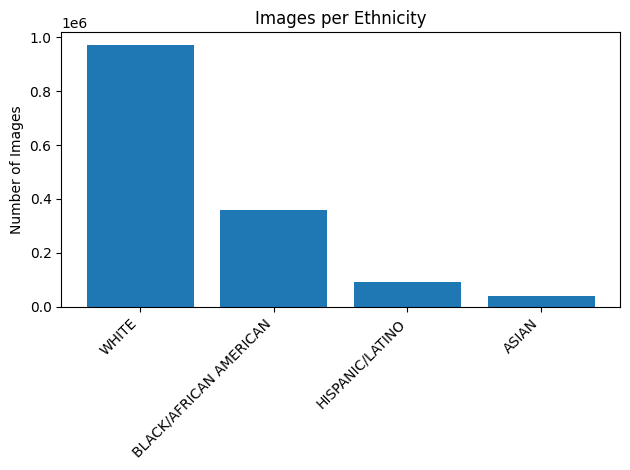

In [56]:
# calculate data demographics
race_counts = labels_df['ethnicity'].value_counts()
print(race_counts)

unique_subject = labels_df['subject_id'].unique()

print(len(unique_subject))

# plotting race distribution
plt.figure()
plt.bar(race_counts.index, race_counts.values)
plt.ylabel('Number of Images')
plt.title('Images per Ethnicity')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

DICOM Preprocessing

In [57]:
import os, pydicom, pandas as pd
from pydicom import config
config.use_gdcm_handler = True

local_path_stem = '/Users/jiwoo_noh/Downloads/physionet.org/files/mimic-cxr/2.1.0/'

valid_rows = []
labels_dict = {}

for _, row in labels_df.iterrows():
    patient_id = row['subject_id']
    full_path  = os.path.join(local_path_stem, row['path'])
    if not os.path.exists(full_path):
        continue

    try:
        ds = pydicom.dcmread(full_path, force=True)
        _  = ds.pixel_array   # will throw if unreadable
    except Exception as e:
        # print(f"Skipping corrupted {full_path}: {e}")
        continue

    new_row = row.copy()
    new_row['path'] = row['path']        
    valid_rows.append(new_row)

    # store for later dataset creation
    labels_dict[(patient_id, full_path)] = row['ethnicity']

# save the new list of patients (this is the data we will actually have access to)
valid_df = pd.DataFrame(valid_rows)

unique_labels = sorted(valid_df['ethnicity'].unique())
label2idx     = {lab: i for i, lab in enumerate(unique_labels)}
idx2label     = {i: lab for lab, i in label2idx.items()}
num_classes   = len(unique_labels)

print("Classes:", unique_labels)
print("Mapping:", label2idx)

# valid_df.to_csv('downloaded_data_info.csv', index=False)


Classes: ['ASIAN', 'BLACK/AFRICAN AMERICAN', 'HISPANIC/LATINO', 'WHITE']
Mapping: {'ASIAN': 0, 'BLACK/AFRICAN AMERICAN': 1, 'HISPANIC/LATINO': 2, 'WHITE': 3}


ethnicity
BLACK/AFRICAN AMERICAN    14358
WHITE                     13859
HISPANIC/LATINO             993
ASIAN                       157
Name: count, dtype: int64
Number of unique patients:374


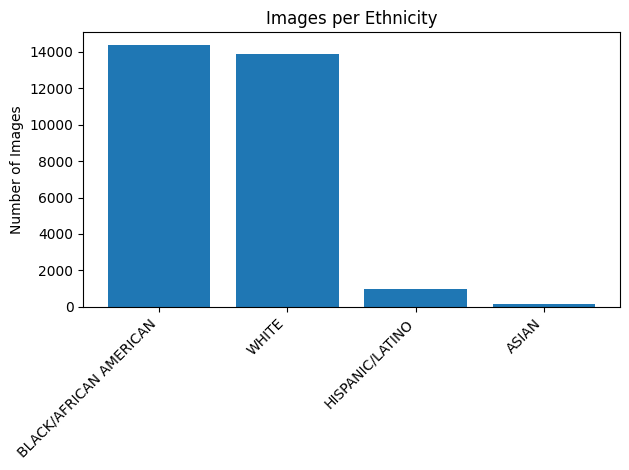

In [58]:
## plot the final patient demographics after filtering and downloading 
race_counts = valid_df['ethnicity'].value_counts()
print(race_counts)

unique_subject = valid_df['subject_id'].unique()

print(f'Number of unique patients:{len(unique_subject)}')

plt.figure()
plt.bar(race_counts.index, race_counts.values)
plt.ylabel('Number of Images')
plt.title('Images per Ethnicity')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [59]:
# by patient train/validation/test split
# stratified by ethnicity
patient_labels = valid_df.groupby('subject_id')['ethnicity'].first()
unique_patients = patient_labels.index.tolist()
patient_label_list = patient_labels.tolist()

# 70 train, val 20, test 10
test_patients, temp_patients = train_test_split(
    unique_patients,
    test_size=0.9,
    stratify=patient_label_list,  # <— keeps your test class‐balance
    random_state=42
)
# now split temp_patients into train / val
temp_labels = patient_labels.loc[temp_patients].tolist()
train_patients, val_patients = train_test_split(
    temp_patients,
    test_size=0.222222,          # ≈20% of original full cohort
    stratify=temp_labels,       
    random_state=42
)

print("Patient size: \n")
print(f"Train size: {len(train_patients)}")
print(f"Val   size: {len(val_patients)}")
print(f"Test  size: {len(test_patients)}")

# complete training, validation, testing datasets because patients have more than one dicom
train_items = []
val_items = []
test_items = []

for (patient_id, path) in labels_dict.keys():
    if patient_id in train_patients:
        train_items.append((patient_id, path))
    elif patient_id in val_patients:
        val_items.append((patient_id, path))
    elif patient_id in test_patients:
        test_items.append((patient_id, path))
    else:
        print("Patient ID: {patient_id} not found in any split but is in the processed images. Something is seriously wrong. Taco.")


# output lists of patient, path pairs as keys
# need to have labels_dict dictionary loaded in --> tensors as items in this dictionary

Patient size: 

Train size: 262
Val   size: 75
Test  size: 37


Train mean: 0.5007,  std: 0.2508


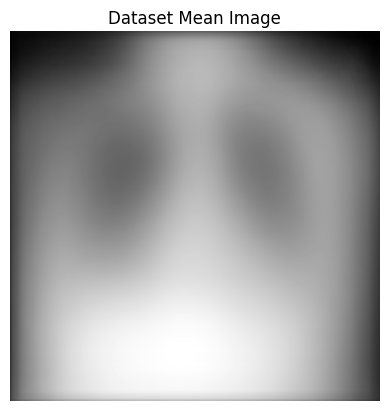

In [60]:
import os
import pydicom
import numpy as np
import random
from PIL import Image

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
# if you ever use CUDA:
torch.cuda.manual_seed_all(SEED)
# make cuDNN deterministic (slower but reproducible)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark     = False

# 1) Dataset class 
class DicomDataset(Dataset):
    def __init__(self, items, labels_dict, label2idx,
                 transform=None, strong_transform=None):
        self.items            = items
        self.labels           = labels_dict
        self.label2idx        = label2idx
        self.transform        = transform
        self.strong_transform = strong_transform

    def __len__(self):
        return len(self.items)

    def __getitem__(self, idx):
        pid, path = self.items[idx]
        ds  = pydicom.dcmread(path)
        arr = ds.pixel_array.astype('float32')
        arr = (arr - arr.min()) / (arr.ptp() + 1e-6)
        img = Image.fromarray((arr * 255).astype('uint8'))

        raw_label = self.labels[(pid, path)]
        # if we have a strong_transform AND this is a minority class, use it
        if (
            raw_label in ['ASIAN', 'HISPANIC/LATINO']
            and self.strong_transform is not None
        ):
            img = self.strong_transform(img)
        else:
            # fallback to the normal one (must be set)
            img = self.transform(img)

        label = self.label2idx[raw_label]
        return img, label


# 2) Compute train‐set mean & std 
def compute_mean_std(loader):
    mean = 0.0
    var  = 0.0
    n    = 0
    for imgs, _ in loader:
        # imgs: [B, 1, H, W]
        b = imgs.size(0)
        imgs = imgs.view(b, imgs.size(1), -1)   # [B, C, H*W]
        mean += imgs.mean(2).sum(0)
        var  += imgs.var(2, unbiased=False).sum(0)
        n    += b
    mean /= n
    var  /= n
    std   = torch.sqrt(var)
    return mean, std


stats_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),   # yields [1,H,W] in [0,1]
])

stats_loader = DataLoader(
    DicomDataset(train_items, labels_dict, label2idx, transform=stats_transform),
    batch_size=32, shuffle=False, num_workers=0
)

train_mean, train_std = compute_mean_std(stats_loader)
print(f"Train mean: {train_mean.item():.4f},  std: {train_std.item():.4f}")

# compute per pixel image for mask later 
# stats_loader yields batches of shape [B,1,224,224] in [0,1]
pixel_sum   = torch.zeros((224,224))
num_samples = 0

for imgs, _ in stats_loader:
    # imgs.squeeze(1): [B,224,224]
    pixel_sum   += imgs.squeeze(1).sum(dim=0)
    num_samples += imgs.size(0)

mean_image = pixel_sum / num_samples  # shape [224,224]

plt.imshow(mean_image.numpy(), cmap='gray')
plt.title("Dataset Mean Image")
plt.axis('off')
plt.show()
torch.save(mean_image, 'mean_image.pt')

# 3) final transforms
train_transform = transforms.Compose([ # data augmentation to prevent overfitting
    transforms.RandomResizedCrop(224, scale=(0.8,1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(0.1,0.1),
    transforms.ToTensor(),
    transforms.Normalize([train_mean.item()], [train_std.item()]),
])

val_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([train_mean.item()], [train_std.item()]),
])

# Stronger transform for asian and hispanic population
strong_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.7, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1,0.1), scale=(0.8,1.2), shear=10),
    transforms.ToTensor(),                     
    transforms.RandomErasing(p=0.3),         
    transforms.Normalize([train_mean.item()], 
                         [train_std.item()]),
])

In [43]:
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.models import densenet121
from torch.utils.data import DataLoader
import pandas as pd
from tqdm import tqdm

# ─── FIX ALL SOURCES OF RANDOMNESS ─────────────────────────────────────────
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark     = False

# ─── Device setup ─────────────────────────────────────────────────────────
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print("Using device:", device)

# ─── Determine number of classes ──────────────────────────────────────────
unique_labels = sorted(set(labels_dict.values()))
num_classes   = len(unique_labels)
print(f"Classes ({num_classes}): {unique_labels}")

# ─── Hyperparameter grid ─────────────────────────────────────────────────
batch_size_options    = [16, 32]
learning_rate_options = [1e-4, 1e-5]
weight_decay_options  = [1e-3, 1e-4]

records = []

for batch_size in batch_size_options:
    for learning_rate in learning_rate_options:
        for weight_decay in weight_decay_options:

            print(f"\n======== batch_size={batch_size}, "
                  f"learning_rate={learning_rate}, "
                  f"weight_decay={weight_decay} ========")

            # ─── DataLoaders (num_workers=0 for determinism) ────────────────
            train_loader = DataLoader(
                DicomDataset(train_items, labels_dict, label2idx,
                             transform=train_transform,
                             strong_transform=strong_transform),
                batch_size=batch_size,
                shuffle=True,
                num_workers=0,
                pin_memory=True
            )
            val_loader = DataLoader(
                DicomDataset(val_items, labels_dict, label2idx,
                             transform=val_transform),
                batch_size=batch_size,
                shuffle=False,
                num_workers=0,
                pin_memory=True
            )
            test_loader = DataLoader(
                DicomDataset(test_items, labels_dict, label2idx,
                             transform=val_transform),
                batch_size=batch_size,
                shuffle=False,
                num_workers=0,
                pin_memory=True
            )

            # ─── Build model ───────────────────────────────────────────────
            model = densenet121(pretrained=True)
            old_conv = model.features.conv0
            new_conv = nn.Conv2d(
                in_channels=1,
                out_channels=old_conv.out_channels,
                kernel_size=old_conv.kernel_size,
                stride=old_conv.stride,
                padding=old_conv.padding,
                bias=(old_conv.bias is not None)
            )
            with torch.no_grad():
                new_conv.weight[:] = old_conv.weight.mean(dim=1, keepdim=True)
                if old_conv.bias is not None:
                    new_conv.bias[:] = old_conv.bias
            model.features.conv0 = new_conv
            model.classifier = nn.Linear(model.classifier.in_features, num_classes)
            model = model.to(device)

            # ─── Loss, optimizer, scheduler ───────────────────────────────
            criterion = nn.CrossEntropyLoss()
            optimizer = optim.Adam(
                model.parameters(),
                lr=learning_rate,
                weight_decay=weight_decay
            )
            scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

            # ─── Training loop with tqdm & metrics ────────────────────────
            best_val_accuracy = 0.0
            for epoch in range(1, 16):
                # — Training —
                model.train()
                train_loss_sum = train_correct = train_total = 0
                train_bar = tqdm(train_loader, desc=f"Epoch {epoch:02d} ▶ Train", leave=False)
                for imgs, labs in train_bar:
                    imgs, labs = imgs.to(device), labs.to(device)
                    optimizer.zero_grad()
                    outputs = model(imgs)
                    loss = criterion(outputs, labs)
                    loss.backward()
                    optimizer.step()

                    bs = labs.size(0)
                    train_loss_sum += loss.item() * bs
                    preds = outputs.argmax(dim=1)
                    train_correct += (preds == labs).sum().item()
                    train_total   += bs

                    train_bar.set_postfix(
                        loss=f"{train_loss_sum/train_total:.4f}",
                        acc =f"{train_correct/train_total:.4f}"
                    )

                # — Validation —
                model.eval()
                val_loss_sum = val_correct = val_total = 0
                val_bar = tqdm(val_loader, desc=f"Epoch {epoch:02d} ▶ Val  ", leave=False)
                with torch.no_grad():
                    for imgs, labs in val_bar:
                        imgs, labs = imgs.to(device), labs.to(device)
                        outputs = model(imgs)
                        loss = criterion(outputs, labs)

                        bs = labs.size(0)
                        val_loss_sum += loss.item() * bs
                        preds = outputs.argmax(dim=1)
                        val_correct += (preds == labs).sum().item()
                        val_total   += bs

                        val_bar.set_postfix(
                            loss=f"{val_loss_sum/val_total:.4f}",
                            acc =f"{val_correct/val_total:.4f}"
                        )

                avg_val_acc = val_correct / val_total
                scheduler.step()
                best_val_accuracy = max(best_val_accuracy, avg_val_acc)

                print(f"Epoch {epoch:02d} ▶ Val Acc: {avg_val_acc:.4f}")

            print(f"→ Best validation accuracy = {best_val_accuracy:.4f}")

            # ─── Save and record ──────────────────────────────────────────
            fname = f"model_bs_{batch_size}_lr_{learning_rate}_wd_{weight_decay}.pt"
            torch.save(model.state_dict(), fname)
            records.append({
                "batch_size":       batch_size,
                "learning_rate":    learning_rate,
                "weight_decay":     weight_decay,
                "best_val_accuracy": best_val_accuracy,
                "model_file":       fname
            })

# ─── Summarize all runs & rename best ───────────────────────────────────────
results_df = pd.DataFrame(records).sort_values("best_val_accuracy", ascending=False).reset_index(drop=True)
print("\nAll runs sorted by validation accuracy:")
print(results_df.to_string(index=False))

best_file = results_df.loc[0, "model_file"]
os.replace(best_file, "densenet_final_test.pt")
print(f"Renamed {best_file} → densenet_final_test.pt")


Using device: mps
Classes (4): ['ASIAN', 'BLACK/AFRICAN AMERICAN', 'HISPANIC/LATINO', 'WHITE']

======== batch_size=16, learning_rate=0.0001, weight_decay=0.001 ========


Epoch 01 ▶ Val Acc: 0.7258


Epoch 02 ▶ Val Acc: 0.7621


Epoch 03 ▶ Val Acc: 0.7675


Epoch 04 ▶ Val Acc: 0.7567


Epoch 05 ▶ Val Acc: 0.7621


Epoch 06 ▶ Val Acc: 0.7487


Epoch 07 ▶ Val Acc: 0.7298


Epoch 08 ▶ Val Acc: 0.7836


Epoch 09 ▶ Val Acc: 0.7970


Epoch 10 ▶ Val Acc: 0.7917


Epoch 11 ▶ Val Acc: 0.7944


Epoch 12 ▶ Val Acc: 0.7890


Epoch 13 ▶ Val Acc: 0.8011


Epoch 14 ▶ Val Acc: 0.7957


Epoch 15 ▶ Val Acc: 0.7970
→ Best validation accuracy = 0.8011

======== batch_size=16, learning_rate=0.0001, weight_decay=0.0001 ========


Epoch 01 ▶ Val Acc: 0.6895


Epoch 02 ▶ Val Acc: 0.7527


Epoch 03 ▶ Val Acc: 0.7325


Epoch 04 ▶ Val Acc: 0.7930


Epoch 05 ▶ Val Acc: 0.7675


Epoch 06 ▶ Val Acc: 0.7809


Epoch 07 ▶ Val Acc: 0.7903


Epoch 08 ▶ Val Acc: 0.7970


Epoch 09 ▶ Val Acc: 0.7997


Epoch 10 ▶ Val Acc: 0.8051


Epoch 11 ▶ Val Acc: 0.7984


Epoch 12 ▶ Val Acc: 0.7930


Epoch 13 ▶ Val Acc: 0.7930


Epoch 14 ▶ Val Acc: 0.7903


Epoch 15 ▶ Val Acc: 0.7997
→ Best validation accuracy = 0.8051

======== batch_size=16, learning_rate=1e-05, weight_decay=0.001 ========


Epoch 01 ▶ Val Acc: 0.6586


Epoch 02 ▶ Val Acc: 0.6599


Epoch 03 ▶ Val Acc: 0.6586


Epoch 04 ▶ Val Acc: 0.6976


Epoch 05 ▶ Val Acc: 0.6815


Epoch 06 ▶ Val Acc: 0.7245


Epoch 07 ▶ Val Acc: 0.7231


Epoch 08 ▶ Val Acc: 0.7325


Epoch 09 ▶ Val Acc: 0.7204


Epoch 10 ▶ Val Acc: 0.7258


Epoch 11 ▶ Val Acc: 0.7285


Epoch 12 ▶ Val Acc: 0.7204


Epoch 13 ▶ Val Acc: 0.7298


Epoch 14 ▶ Val Acc: 0.7406


Epoch 15 ▶ Val Acc: 0.7460
→ Best validation accuracy = 0.7460

======== batch_size=16, learning_rate=1e-05, weight_decay=0.0001 ========


Epoch 01 ▶ Val Acc: 0.6653


Epoch 02 ▶ Val Acc: 0.6801


Epoch 03 ▶ Val Acc: 0.7056


Epoch 04 ▶ Val Acc: 0.7312


Epoch 05 ▶ Val Acc: 0.7379


Epoch 06 ▶ Val Acc: 0.7540


Epoch 07 ▶ Val Acc: 0.7567


Epoch 08 ▶ Val Acc: 0.7567


Epoch 09 ▶ Val Acc: 0.7581


Epoch 10 ▶ Val Acc: 0.7540


Epoch 11 ▶ Val Acc: 0.7594


Epoch 12 ▶ Val Acc: 0.7594


Epoch 13 ▶ Val Acc: 0.7540


Epoch 14 ▶ Val Acc: 0.7634


Epoch 15 ▶ Val Acc: 0.7608
→ Best validation accuracy = 0.7634

======== batch_size=32, learning_rate=0.0001, weight_decay=0.001 ========


Epoch 01 ▶ Val Acc: 0.7231


Epoch 02 ▶ Val Acc: 0.7567


Epoch 03 ▶ Val Acc: 0.7500


Epoch 04 ▶ Val Acc: 0.7702


Epoch 05 ▶ Val Acc: 0.7876


Epoch 06 ▶ Val Acc: 0.7863


Epoch 07 ▶ Val Acc: 0.8011


Epoch 08 ▶ Val Acc: 0.8065


Epoch 09 ▶ Val Acc: 0.8038


Epoch 10 ▶ Val Acc: 0.7970


Epoch 11 ▶ Val Acc: 0.8024


Epoch 12 ▶ Val Acc: 0.7997


Epoch 13 ▶ Val Acc: 0.7970


Epoch 14 ▶ Val Acc: 0.7984


Epoch 15 ▶ Val Acc: 0.7957
→ Best validation accuracy = 0.8065

======== batch_size=32, learning_rate=0.0001, weight_decay=0.0001 ========


Epoch 01 ▶ Val Acc: 0.7433


Epoch 02 ▶ Val Acc: 0.7164


Epoch 03 ▶ Val Acc: 0.7419


Epoch 04 ▶ Val Acc: 0.7809


Epoch 05 ▶ Val Acc: 0.6868


Epoch 06 ▶ Val Acc: 0.8091


Epoch 07 ▶ Val Acc: 0.7944


Epoch 08 ▶ Val Acc: 0.7930


Epoch 09 ▶ Val Acc: 0.7984


Epoch 10 ▶ Val Acc: 0.7944


Epoch 11 ▶ Val Acc: 0.7890


Epoch 12 ▶ Val Acc: 0.7890


Epoch 13 ▶ Val Acc: 0.7970


Epoch 14 ▶ Val Acc: 0.7903


Epoch 15 ▶ Val Acc: 0.7930
→ Best validation accuracy = 0.8091

======== batch_size=32, learning_rate=1e-05, weight_decay=0.001 ========


Epoch 01 ▶ Val Acc: 0.5847


Epoch 02 ▶ Val Acc: 0.6626


Epoch 03 ▶ Val Acc: 0.6707


Epoch 04 ▶ Val Acc: 0.6801


Epoch 05 ▶ Val Acc: 0.7097


Epoch 06 ▶ Val Acc: 0.7231


Epoch 07 ▶ Val Acc: 0.7191


Epoch 08 ▶ Val Acc: 0.7218


Epoch 09 ▶ Val Acc: 0.7204


Epoch 10 ▶ Val Acc: 0.7258


Epoch 11 ▶ Val Acc: 0.7272


Epoch 12 ▶ Val Acc: 0.7231


Epoch 13 ▶ Val Acc: 0.7272


Epoch 14 ▶ Val Acc: 0.7245


Epoch 15 ▶ Val Acc: 0.7312
→ Best validation accuracy = 0.7312

======== batch_size=32, learning_rate=1e-05, weight_decay=0.0001 ========


Epoch 01 ▶ Val Acc: 0.4933


Epoch 02 ▶ Val Acc: 0.6384


Epoch 03 ▶ Val Acc: 0.6734


Epoch 04 ▶ Val Acc: 0.6868


Epoch 05 ▶ Val Acc: 0.7124


Epoch 06 ▶ Val Acc: 0.7245


Epoch 07 ▶ Val Acc: 0.7339


Epoch 08 ▶ Val Acc: 0.7352


Epoch 09 ▶ Val Acc: 0.7379


Epoch 10 ▶ Val Acc: 0.7352


Epoch 11 ▶ Val Acc: 0.7339


Epoch 12 ▶ Val Acc: 0.7325


Epoch 13 ▶ Val Acc: 0.7245


Epoch 14 ▶ Val Acc: 0.7339


Epoch 15 ▶ Val Acc: 0.7339
→ Best validation accuracy = 0.7379

All runs sorted by validation accuracy:
 batch_size  learning_rate  weight_decay  best_val_accuracy                         model_file
         32        0.00010        0.0001           0.809140 model_bs_32_lr_0.0001_wd_0.0001.pt
         32        0.00010        0.0010           0.806452  model_bs_32_lr_0.0001_wd_0.001.pt
         16        0.00010        0.0001           0.805108 model_bs_16_lr_0.0001_wd_0.0001.pt
         16        0.00010        0.0010           0.801075  model_bs_16_lr_0.0001_wd_0.001.pt
         16        0.00001        0.0001           0.763441  model_bs_16_lr_1e-05_wd_0.0001.pt
         16        0.00001        0.0010           0.745968   model_bs_16_lr_1e-05_wd_0.001.pt
         32        0.00001        0.0001           0.737903  model_bs_32_lr_1e-05_wd_0.0001.pt
         32        0.00001        0.0010           0.731183   model_bs_32_lr_1e-05_wd_0.001.pt
Renamed model_bs_32_lr_0.0001_wd_0.0001.p

In [50]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark     = False

batch_size = test_loader.batch_size
# chunk your flat list into the same batch‐sized groups
batched_items = [
    test_items[i : i+batch_size]
    for i in range(0, len(test_items), batch_size)
]

all_pids, all_paths, all_preds, all_probs, all_truths = [], [], [], [], []

model.load_state_dict(torch.load("densenet_final_test.pt"))
model.eval()

# Compute test accuracy ───────────────────────────────────────────────
correct = 0
total   = 0
with torch.no_grad():
    for imgs, labs in test_loader:
        imgs, labs = imgs.to(device), labs.to(device)
        out   = model(imgs)
        preds = out.argmax(dim=1)
        correct += (preds == labs).sum().item()
        total   += labs.size(0)

test_acc = correct / total
print(f"Test Accuracy: {test_acc:.4f}")

with torch.no_grad():
    for (imgs, labs), batch in zip(test_loader, batched_items):
        imgs = imgs.to(device)
        out  = model(imgs)
        probs = torch.softmax(out, dim=1)
        preds = probs.argmax(dim=1)

        labs_cpu  = labs.cpu().tolist()
        preds_cpu = preds.cpu().tolist()
        probs_cpu = probs.cpu().tolist()

        # now `batch` is a list of (pid,path) of length == imgs.size(0)
        for (pid,path), truth_idx, pred_idx, prob in zip(
            batch, labs_cpu, preds_cpu, probs_cpu
        ):
            all_pids.append(pid)
            all_paths.append(path)
            all_truths.append(idx2label[truth_idx])
            all_preds.append(idx2label[pred_idx])
            all_probs.append(prob)

import pandas as pd
df = pd.DataFrame({
    "subject_id":   all_pids,
    "dicom_path":   all_paths,
    "true_label":   all_truths,
    "predicted":    all_preds,
    "probabilities": all_probs,
})
# df.to_csv("best_model_pred_final.csv", index=False)
# print("Saved best_model_pred_final.csv with", len(df), "rows.")


Test Accuracy: 0.8504


Classification Report:

                        precision    recall  f1-score   support

                 ASIAN       0.00      0.00      0.00         3
BLACK/AFRICAN AMERICAN       0.71      0.79      0.75        84
       HISPANIC/LATINO       0.00      0.00      0.00        32
                 WHITE       0.89      0.97      0.93       302

              accuracy                           0.85       421
             macro avg       0.40      0.44      0.42       421
          weighted avg       0.78      0.85      0.81       421



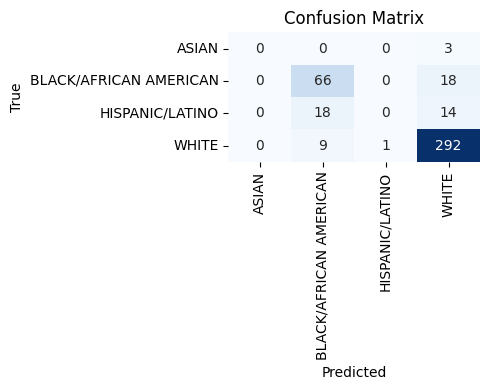

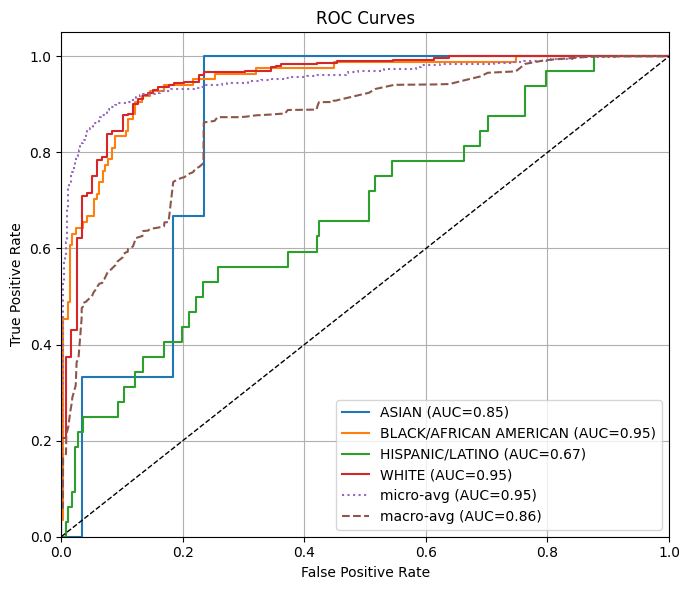

In [51]:
import os, random
import numpy as np
import torch

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark     = False

from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    precision_recall_fscore_support,
    roc_curve,
    auc,
)
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# 1) Collect predictions, labels, and probabilities
model.eval()
all_preds, all_labels, all_probs = [], [], []

with torch.no_grad():
    for imgs, labs in test_loader:
        imgs = imgs.to(device)
        out  = model(imgs)                  # logits
        probs = torch.softmax(out, dim=1)   # [B,C]
        preds = probs.argmax(dim=1)

        all_preds.append(preds.cpu().numpy())
        all_labels.append(labs.numpy())
        all_probs.append(probs.cpu().numpy())

all_preds  = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels)
all_probs  = np.vstack(all_probs)  # shape (N, C)

# 2) Classification report & per‑class precision/recall/f1/support
print("Classification Report:\n")
print(classification_report(
    all_labels,
    all_preds,
    labels=list(range(len(unique_labels))),
    target_names=unique_labels,
    zero_division=0
))

# 3) Confusion matrix
cm = confusion_matrix(all_labels, all_preds, labels=list(range(len(unique_labels))))
fig, ax = plt.subplots(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=unique_labels,
            yticklabels=unique_labels,
            cmap="Blues", cbar=False,
            ax=ax)
ax.set_xlabel("Predicted")
ax.set_ylabel("True")
ax.set_title("Confusion Matrix")
plt.tight_layout()

# save to disk
# fig.savefig("confusion_matrix_best_final.jpg", dpi=300)
plt.show()
plt.close(fig)

# 4) ROC Curves & AUC
n_classes = len(unique_labels)
fpr, tpr, roc_auc = {}, {}, {}

# per-class ROC & AUC
for i in range(n_classes):
    y_true_i  = (all_labels == i).astype(int)
    y_score_i = all_probs[:, i]
    if 0 < y_true_i.sum() < len(y_true_i):
        fpr[i], tpr[i], _ = roc_curve(y_true_i, y_score_i)
        roc_auc[i] = auc(fpr[i], tpr[i])

# micro-average (treat every element of every class equally)
y_true_bin = np.eye(n_classes)[all_labels]  # one-hot encode
fpr["micro"], tpr["micro"], _ = roc_curve(
    y_true_bin.ravel(), all_probs.ravel()
)
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# macro-average (unweighted mean of class‐wise curves)
# 1) aggregate all fpr points
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes) if i in fpr]))
# 2) interpolate each class’s tpr at these points, then average
mean_tpr = np.zeros_like(all_fpr)
seen = 0
for i in range(n_classes):
    if i in fpr:
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
        seen += 1
mean_tpr /= seen
fpr["macro"], tpr["macro"] = all_fpr, mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# 5) Plot & save to disk
fig, ax = plt.subplots(figsize=(7,6))
for i in range(n_classes):
    if i in roc_auc:
        ax.plot(fpr[i], tpr[i],
                label=f"{unique_labels[i]} (AUC={roc_auc[i]:.2f})")
ax.plot(fpr["micro"], tpr["micro"],
        label=f"micro-avg (AUC={roc_auc['micro']:.2f})", linestyle=':')
ax.plot(fpr["macro"], tpr["macro"],
        label=f"macro-avg (AUC={roc_auc['macro']:.2f})", linestyle='--')
ax.plot([0,1], [0,1], "k--", lw=1)

ax.set_xlim(0,1)
ax.set_ylim(0,1.05)
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.set_title("ROC Curves")
ax.legend(loc="lower right")
ax.grid(True)
plt.tight_layout()

# save figure
# fig.savefig("roc_curves_best_final.jpg", dpi=300)
plt.show()
plt.close(fig)


In [22]:
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
import shap
from tqdm import tqdm

# —————————————————————————————
#  CONFIGURATION
# —————————————————————————————
samples_per_class = 1            # how many correct examples per class
device = next(model.parameters()).device
model.eval()

# 1) Build a small background on CPU
bg_size = 50
# gather raw inputs (still on GPU if your dataset gives GPU tensors)
all_inputs = [train_loader.dataset[i][0] for i in range(len(train_loader.dataset))]
background = torch.stack(
    np.random.choice(all_inputs, bg_size, replace=False)
).cpu()  # SHAP wants CPU tensors  
# copy model to CPU for explainer
model_cpu = model.to('cpu')
explainer = shap.GradientExplainer(model_cpu, background)

# 2) For each class, find one correctly predicted sample (on GPU → then CPU)
results = []
for cls_idx, cls_name in enumerate(unique_labels):
    found_tensor = None
    for imgs, labs in test_loader:
        imgs, labs = imgs.to(device), labs.to(device)
        with torch.no_grad():
            preds = model(imgs).argmax(1)
        # look for a match
        for b in range(imgs.size(0)):
            if labs[b].item() == cls_idx and preds[b].item() == cls_idx:
                found_tensor = imgs[b:b+1].cpu()  # bring to CPU
                break
        if found_tensor is not None:
            break

    if found_tensor is None:
        print(f"⚠️  no correct example for {cls_name}, skipping")
        continue

    # 3) Compute SHAP values (CPU)
    shap_values = explainer.shap_values(found_tensor)  # list length = #classes
    # pick the array for this class
    arr = shap_values[cls_idx]
    # convert tensor→numpy if needed
    if isinstance(arr, torch.Tensor):
        arr = arr.detach().cpu().numpy()

    # arr shape is (1, C, H, W). We'll take channel 0.
    shap_map = arr[0, 0]   # H×W

    # also grab the original pixel for overlay
    pixel = found_tensor.numpy()[0, 0]  # H×W

    results.append((cls_name, pixel, shap_map))

if not results:
    raise RuntimeError("No correctly predicted samples found to explain!")

# 4) Plot one row per class found
n = len(results)
fig, axes = plt.subplots(nrows=n, ncols=2, figsize=(6, 3*n), squeeze=False)

for i, (cls_name, pixel, shap_map) in enumerate(results):
    # normalize & resize shap_map to pixel size
    a = np.abs(shap_map)
    a = (a - a.min())/(a.max() - a.min() + 1e-8)
    cam = cv2.resize(a, (pixel.shape[1], pixel.shape[0]), interpolation=cv2.INTER_LINEAR)

    # create heat & overlay
    heat = cv2.applyColorMap((cam*255).astype(np.uint8), cv2.COLORMAP_JET)[...,::-1]/255.0
    overlay = 0.6*np.dstack([pixel]*3) + 0.4*heat

    # original
    ax = axes[i,0]
    ax.imshow(pixel, cmap='gray')
    ax.set_title(f"{cls_name}")
    ax.axis('off')

    # SHAP overlay
    ax = axes[i,1]
    ax.imshow(overlay)
    ax.set_title("SHAP overlay")
    ax.axis('off')

plt.tight_layout()
plt.show()


ValueError: a must be 1-dimensional

/Users/jiwoo_noh/Library/Python/3.9/lib/python/site-packages/torch/nn/modules/module.py:1373: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.2086877822875977..1.6022702693939208].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.2086877822875977..1.299718701839447].


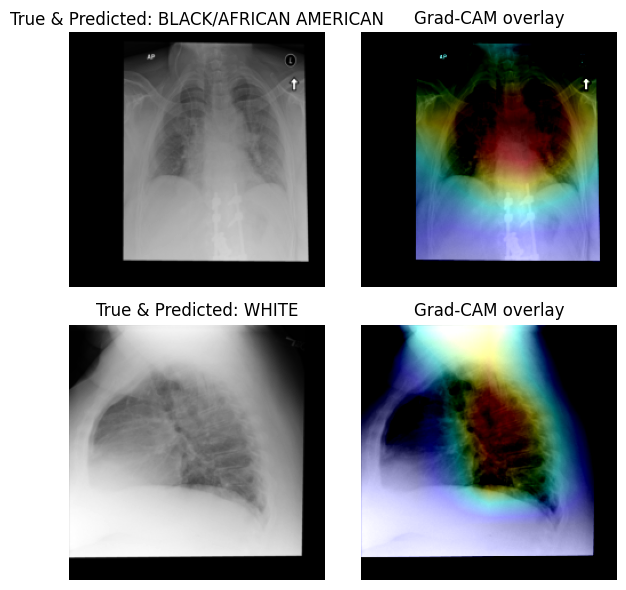

In [23]:
# Grad-CAM

import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm

# assume `model`, `test_loader`, and `unique_labels` are already defined
device = next(model.parameters()).device
model.eval()

# 1) pick one correctly classified example per class
sample_imgs, sample_labels = [], []
for cls_idx, cls_name in enumerate(unique_labels):
    found = False
    for imgs, labs in test_loader:
        imgs, labs = imgs.to(device), labs.to(device)
        with torch.no_grad():
            preds = model(imgs).argmax(1)
        for b in range(imgs.size(0)):
            if labs[b].item() == cls_idx and preds[b].item() == cls_idx:
                sample_imgs.append(imgs[b].cpu())
                sample_labels.append(cls_idx)
                found = True
                break
        if found:
            break

if len(sample_imgs) == 0:
    raise RuntimeError("No correctly predicted samples found!")

# stack into (N,1,H,W)
sample_imgs = torch.stack(sample_imgs)

# 2) register hooks on the last DenseNet feature map
activations = {}
gradients   = {}
def forward_hook(module, inp, out):
    activations['feat'] = out
def backward_hook(module, grad_in, grad_out):
    gradients['grad'] = grad_out[0]

target_layer = model.features.norm5
fh = target_layer.register_forward_hook(forward_hook)
bh = target_layer.register_backward_hook(backward_hook)

# 3) compute Grad-CAM maps
cams = []
for i in range(sample_imgs.size(0)):
    x = sample_imgs[i:i+1].to(device)
    model.zero_grad()
    out = model(x)
    cls = sample_labels[i]
    out[0, cls].backward()

    feat = activations['feat'][0]    # C×h×w
    grad = gradients  ['grad'][0]    # C×h×w
    weights = grad.mean(dim=(1,2))   # C
    cam = (weights[:,None,None] * feat).sum(dim=0).cpu().detach().numpy()
    cam = np.maximum(cam, 0)
    cams.append(cam)

# remove hooks
fh.remove()
bh.remove()

# 4) visualize: N×2 grid
n = sample_imgs.size(0)
fig, axes = plt.subplots(nrows=n, ncols=2, figsize=(6, 3*n), squeeze=False)

for i in range(n):
    # original image
    img = sample_imgs[i,0].numpy()  # H×W

    # process CAM → upsample → colourmap → overlay
    cam  = cams[i]
    cam  = (cam - cam.min())/(cam.max()-cam.min()+1e-8)
    cam  = cv2.resize(cam, (img.shape[1], img.shape[0]),
                      interpolation=cv2.INTER_LINEAR)
    heat = cv2.applyColorMap((cam*255).astype(np.uint8),
                              cv2.COLORMAP_JET)[...,::-1]/255.0
    overlay = 0.4*heat + 0.6*np.dstack([img]*3)

    # plot original
    ax = axes[i,0]
    lbl = unique_labels[sample_labels[i]]
    ax.imshow(img, cmap='gray')
    ax.set_title(f"True & Predicted: {lbl}")
    ax.axis('off')

    # plot Grad-CAM overlay
    ax = axes[i,1]
    ax.imshow(overlay)
    ax.set_title("Grad-CAM overlay")
    ax.axis('off')

plt.tight_layout()
plt.show()
